# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en matlab


In [2]:
import scipy.io as sio
import hdf5storage
datos_matlab = hdf5storage.loadmat('../datos_octubre_2018/conjunto_entrenamiento_octubre_2018_red_pitch5mm_rad161mm_total.mat')
conjunto_datos= datos_matlab.get('photodefA')
conjunto_datos.shape

(66498, 640)

In [3]:
import os
import pandas as pd
dir_name='../datos_octubre_2018'
base_filename='p_OF_5mm_161mm'
filename_suffix='.h5'
file=os.path.join(dir_name, base_filename+ "{0:03d}".format(0) + filename_suffix)
conjunto_datos_waves=pd.read_hdf(file,'MC')
datos_waves=conjunto_datos_waves.values
datos_waves.shape

(6320, 3840)

In [4]:
for i in range(1,2):
    file=os.path.join(dir_name, base_filename+ "{0:03d}".format(i) + filename_suffix)
    #print(file)
    veamos=pd.read_hdf(file,'MC')
    veamos_array=veamos.values
    datos_waves=np.concatenate((datos_waves,veamos_array),axis=0)
datos_waves.shape

(12641, 3840)

In [5]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
# input image dimensions
img_rows, img_cols = 16, 40

X_trained=datos_waves;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;

print(x_trained.shape)


(12641, 3840)


In [6]:
input_output_dim_A=img_rows*img_cols
ideaA=np.zeros((L1A,input_output_dim_A))

conjunto_datos=np.zeros((x_trained.shape[0]*L1A,input_output_dim_A))
for i in range(x_trained.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_trained[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    conjunto_datos[(i)*L1A :(i+1)*L1A,:] = ideaA    
    

  

## Network parameters:

In [7]:
use_regularizer = True
my_regularizer = None
my_epochs = 50
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l2(0.001)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

   
    
encoding_dim = 250  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder

input_img = Input(shape=(img_rows*img_cols,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh', use_bias=False,bias_initializer='random_uniform')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(img_cols*img_rows, activation='tanh',use_bias=True,bias_initializer='random_uniform')(encoded)

# this model maps an input to its reconstruction


#autoencoder=Sequential([
#    Dense(encoding_dim, kernel_regularizer=regularizers.l2(0.001), use_bias=True,bias_initializer='random_uniform',input_shape=(640,)),
#    Activation('sigmoid'),
#    Dense(img_cols*img_rows, use_bias=True,bias_initializer='random_uniform'),
#    Activation('linear'),
#])

autoencoder = Model(input_img, decoded)

## Prepare data into training and test set.

In [8]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)

tr_size=60
val_size=20
test_size=100-val_size-tr_size

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


X_train=conjunto_datos[:tamanyo_tr,:]
X_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,:]
X_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,:]





Y_train=conjunto_datos[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

75846
conjunto_datos shape: (75846, 640)
45507
15169
15170


In [9]:
X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows,1)
X_val = X_val.reshape(X_val.shape[0], img_cols, img_rows,1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows,1)


input_shape = (img_cols, img_rows,1)
#input_shape=input_shape.astype('int32')

In [10]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45507, 40, 16, 1)
45507 train samples
15169 validation samples
15170 test samples


Display 20 random training images using image

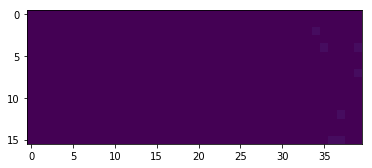

42685


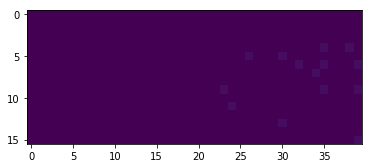

20489


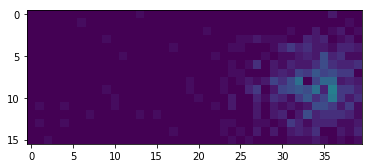

19624


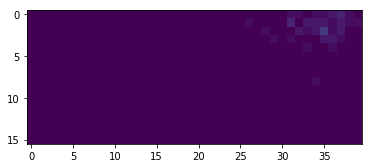

30003


In [11]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea].transpose(), [16, 40]), vmin=0, vmax=30)
    plt.viridis()
    plt.show()
    print(idea)

Vamos a generar las matrices de datos para la red neuronal 

In [12]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
x_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
prueba=x_train[0:15170,:]
print(x_train.shape)
print(x_test.shape)
print(prueba.shape)

(45507, 640)
(15170, 640)
(15170, 640)


In [13]:
# min_max_scaler = preprocessing.QuantileTransformer().fit(x_train)
# min_max_scaler = preprocessing.MaxAbsScaler().fit(x_train)
# min_max_scaler = preprocessing.StandardScaler(with_mean=False).fit(x_train)
min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
supermax=100
factor_aprendizaje=0.0001
print(min_max_scaler)
#x_train_scaled = min_max_scaler.transform(x_train)
#x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled=(2*x_train/supermax)-1
x_test_scaled=(2*x_test/supermax)-1
#min_max_scaler.scale_
x_train[29413]
x_train_scaled[29413]

MinMaxScaler(copy=True, feature_range=(0, 1))


array([-0.98, -1.  , -1.  , -1.  , -0.98, -0.98, -1.  , -0.94, -1.  ,
       -0.92, -0.96, -0.98, -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
       -1.  , -1.  , -1.  , -0.96, -0.94, -0.92, -0.98, -1.  , -0.96,
       -0.98, -0.96, -0.98, -0.96, -0.98, -1.  , -0.98, -0.98, -0.98,
       -0.96, -1.  , -0.92, -0.9 , -0.92, -0.98, -1.  , -1.  , -0.98,
       -0.98, -0.96, -0.98, -1.  , -1.  , -0.98, -1.  , -0.98, -0.96,
       -0.94, -0.96, -0.98, -1.  , -0.92, -0.92, -0.92, -1.  , -0.98,
       -0.98, -0.98, -1.  , -0.98, -1.  , -0.98, -0.94, -0.98, -0.98,
       -0.96, -0.98, -0.96, -0.94, -0.98, -1.  , -0.98, -0.98, -1.  ,
       -1.  , -1.  , -1.  , -0.98, -0.96, -0.96, -0.98, -0.94, -0.92,
       -0.94, -0.94, -0.98, -0.94, -1.  , -0.96, -1.  , -1.  , -0.98,
       -1.  , -1.  , -0.96, -0.98, -0.96, -0.98, -0.96, -1.  , -0.94,
       -0.96, -0.98, -0.96, -1.  , -1.  , -1.  , -1.  , -1.  , -1.  ,
       -1.  , -0.96, -0.94, -0.96, -0.98, -1.  , -0.98, -0.94, -1.  ,
       -1.  , -0.98,

## Build the autoencoder. 

In [14]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='RMSprop', loss='mse')

autoencoder.optimizer.lr=(factor_aprendizaje)

Show a summary of the model parameters. 

And now train the model and evaluate on the test set. 

In [15]:
algoritmo='RMSprop'
experimento="scaled_{}_encoder_without_bias_tanh_tanh_lr_{}".format(supermax,factor_aprendizaje)
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/{}{}{}{}".format(encoding_dim,algoritmo,experimento,datetime.now()))
#modelCheckpoint=ModelCheckpoint("/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
autoencoder.fit(x_train_scaled, x_train_scaled,
                epochs=10000,
                batch_size=200,
                shuffle=False,
                callbacks=[tensorboard, early_stop],
                validation_data=(x_test_scaled, x_test_scaled))



Train on 45507 samples, validate on 15170 samples
Epoch 1/10000
45507/45507 [==============================] - 1s 29us/step - loss: 0.0799 - val_loss: 0.0012
Epoch 2/10000
45507/45507 [==============================] - 1s 28us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10000
45507/45507 [==============================] - 1s 30us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/10000
45507/45507 [==============================] - 2s 35us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/10000
45507/45507 [==============================] - 2s 37us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10000
45507/45507 [==============================] - 1s 28us/step - loss: 0.00

45507/45507 [==============================] - 2s 35us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 76/10000
45507/45507 [==============================] - 2s 37us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 77/10000
45507/45507 [==============================] - 2s 37us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 78/10000
45507/45507 [==============================] - 1s 32us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 79/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 80/10000
45507/45507 [==============================] - 1s 33us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 81/10000
45507/45507 [==============================] - 1s 32us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 82/10000
45507/45507 [==============================] - 2s 33us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 83/10000
45507/45507 [==============================] - 2s 36us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 84/10000
45507/45507 [======

Epoch 148/10000
45507/45507 [==============================] - 2s 35us/step - loss: 8.6045e-04 - val_loss: 8.6374e-04
Epoch 149/10000
45507/45507 [==============================] - 2s 36us/step - loss: 8.5629e-04 - val_loss: 8.5998e-04
Epoch 150/10000
45507/45507 [==============================] - 2s 36us/step - loss: 8.5213e-04 - val_loss: 8.5618e-04
Epoch 151/10000
45507/45507 [==============================] - 2s 35us/step - loss: 8.4805e-04 - val_loss: 8.5238e-04
Epoch 152/10000
45507/45507 [==============================] - 2s 35us/step - loss: 8.4405e-04 - val_loss: 8.4862e-04
Epoch 153/10000
45507/45507 [==============================] - 2s 36us/step - loss: 8.4015e-04 - val_loss: 8.4491e-04
Epoch 154/10000
45507/45507 [==============================] - 2s 36us/step - loss: 8.3637e-04 - val_loss: 8.4123e-04
Epoch 155/10000
45507/45507 [==============================] - 2s 34us/step - loss: 8.3273e-04 - val_loss: 8.3755e-04
Epoch 156/10000
45507/45507 [===========================

45507/45507 [==============================] - 2s 35us/step - loss: 7.2047e-04 - val_loss: 7.1967e-04
Epoch 218/10000
45507/45507 [==============================] - 2s 34us/step - loss: 7.1961e-04 - val_loss: 7.1864e-04
Epoch 219/10000
45507/45507 [==============================] - 1s 26us/step - loss: 7.1877e-04 - val_loss: 7.1764e-04
Epoch 220/10000
45507/45507 [==============================] - 1s 30us/step - loss: 7.1794e-04 - val_loss: 7.1670e-04
Epoch 221/10000
45507/45507 [==============================] - 2s 37us/step - loss: 7.1712e-04 - val_loss: 7.1579e-04
Epoch 222/10000
45507/45507 [==============================] - 2s 36us/step - loss: 7.1631e-04 - val_loss: 7.1492e-04
Epoch 223/10000
45507/45507 [==============================] - 2s 34us/step - loss: 7.1551e-04 - val_loss: 7.1409e-04
Epoch 224/10000
45507/45507 [==============================] - 2s 36us/step - loss: 7.1473e-04 - val_loss: 7.1330e-04
Epoch 225/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 35us/step - loss: 6.8093e-04 - val_loss: 6.9910e-04
Epoch 287/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.8058e-04 - val_loss: 6.9895e-04
Epoch 288/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.8023e-04 - val_loss: 6.9881e-04
Epoch 289/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.7988e-04 - val_loss: 6.9868e-04
Epoch 290/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.7954e-04 - val_loss: 6.9857e-04
Epoch 291/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.7920e-04 - val_loss: 6.9848e-04
Epoch 292/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.7886e-04 - val_loss: 6.9840e-04
Epoch 293/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.7852e-04 - val_loss: 6.9833e-04
Epoch 294/10000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 35us/step - loss: 6.6337e-04 - val_loss: 6.9168e-04
Epoch 356/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.6318e-04 - val_loss: 6.9193e-04
Epoch 357/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.6296e-04 - val_loss: 6.9220e-04
Epoch 358/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.6276e-04 - val_loss: 6.9248e-04
Epoch 359/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.6256e-04 - val_loss: 6.9306e-04
Epoch 360/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.6236e-04 - val_loss: 6.9395e-04
Epoch 361/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.6216e-04 - val_loss: 6.9465e-04
Epoch 362/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.6198e-04 - val_loss: 6.9475e-04
Epoch 363/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.5160e-04 - val_loss: 6.7562e-04
Epoch 425/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.5146e-04 - val_loss: 6.7660e-04
Epoch 426/10000
45507/45507 [==============================] - 1s 31us/step - loss: 6.5132e-04 - val_loss: 6.7765e-04
Epoch 427/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.5119e-04 - val_loss: 6.7900e-04
Epoch 428/10000
45507/45507 [==============================] - 1s 26us/step - loss: 6.5106e-04 - val_loss: 6.8033e-04
Epoch 429/10000
45507/45507 [==============================] - 1s 29us/step - loss: 6.5096e-04 - val_loss: 6.8155e-04
Epoch 430/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.5097e-04 - val_loss: 6.8172e-04
Epoch 431/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.5087e-04 - val_loss: 6.8508e-04
Epoch 432/10000
45507/45507 [==============================] - 2s 36us/s

45507/45507 [==============================] - 2s 37us/step - loss: 6.4606e-04 - val_loss: 6.7964e-04
Epoch 494/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.4510e-04 - val_loss: 6.7194e-04
Epoch 495/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.4498e-04 - val_loss: 6.7423e-04
Epoch 496/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.4553e-04 - val_loss: 6.8056e-04
Epoch 497/10000
45507/45507 [==============================] - 2s 33us/step - loss: 6.4521e-04 - val_loss: 6.7860e-04
Epoch 498/10000
45507/45507 [==============================] - 1s 30us/step - loss: 6.4536e-04 - val_loss: 6.7472e-04
Epoch 499/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.4450e-04 - val_loss: 6.9648e-04
Epoch 500/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.4544e-04 - val_loss: 6.8159e-04
Epoch 501/10000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 1s 24us/step - loss: 6.3861e-04 - val_loss: 6.7832e-04
Epoch 563/10000
45507/45507 [==============================] - 1s 28us/step - loss: 6.3844e-04 - val_loss: 6.7985e-04
Epoch 564/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.3881e-04 - val_loss: 6.7929e-04
Epoch 565/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3878e-04 - val_loss: 6.7581e-04
Epoch 566/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.3851e-04 - val_loss: 6.7288e-04
Epoch 567/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.3764e-04 - val_loss: 6.7880e-04
Epoch 568/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3813e-04 - val_loss: 6.5705e-04
Epoch 569/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.3856e-04 - val_loss: 6.6424e-04
Epoch 570/10000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.3396e-04 - val_loss: 6.6208e-04
Epoch 632/10000
45507/45507 [==============================] - 1s 31us/step - loss: 6.3340e-04 - val_loss: 6.6204e-04
Epoch 633/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3369e-04 - val_loss: 6.5313e-04
Epoch 634/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.3404e-04 - val_loss: 6.5353e-04
Epoch 635/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3318e-04 - val_loss: 6.6898e-04
Epoch 636/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3366e-04 - val_loss: 6.5412e-04
Epoch 637/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.3293e-04 - val_loss: 6.5869e-04
Epoch 638/10000
45507/45507 [==============================] - 1s 25us/step - loss: 6.3305e-04 - val_loss: 6.5451e-04
Epoch 639/10000
45507/45507 [==============================] - 1s 26us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.2828e-04 - val_loss: 6.5169e-04
Epoch 701/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2817e-04 - val_loss: 6.5415e-04
Epoch 702/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2791e-04 - val_loss: 6.5285e-04
Epoch 703/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.2778e-04 - val_loss: 6.5259e-04
Epoch 704/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2788e-04 - val_loss: 6.5330e-04
Epoch 705/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.2740e-04 - val_loss: 6.5356e-04
Epoch 706/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2770e-04 - val_loss: 6.5310e-04
Epoch 707/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2795e-04 - val_loss: 6.5268e-04
Epoch 708/10000
45507/45507 [==============================] - 2s 34us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.2283e-04 - val_loss: 6.4578e-04
Epoch 770/10000
45507/45507 [==============================] - 1s 31us/step - loss: 6.2248e-04 - val_loss: 6.4590e-04
Epoch 771/10000
45507/45507 [==============================] - 1s 29us/step - loss: 6.2231e-04 - val_loss: 6.4725e-04
Epoch 772/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.2245e-04 - val_loss: 6.4554e-04
Epoch 773/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2200e-04 - val_loss: 6.4598e-04
Epoch 774/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.2252e-04 - val_loss: 6.4558e-04
Epoch 775/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.2201e-04 - val_loss: 6.4591e-04
Epoch 776/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.2216e-04 - val_loss: 6.4624e-04
Epoch 777/10000
45507/45507 [==============================] - 2s 37us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.1721e-04 - val_loss: 6.3862e-04
Epoch 839/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.1716e-04 - val_loss: 6.3863e-04
Epoch 840/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.1715e-04 - val_loss: 6.3849e-04
Epoch 841/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.1704e-04 - val_loss: 6.3914e-04
Epoch 842/10000
45507/45507 [==============================] - 2s 33us/step - loss: 6.1690e-04 - val_loss: 6.3881e-04
Epoch 843/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.1684e-04 - val_loss: 6.3837e-04
Epoch 844/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.1678e-04 - val_loss: 6.3877e-04
Epoch 845/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.1672e-04 - val_loss: 6.3873e-04
Epoch 846/10000
45507/45507 [==============================] - 1s 30us/s

45507/45507 [==============================] - 2s 37us/step - loss: 6.1241e-04 - val_loss: 6.3286e-04
Epoch 908/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.1250e-04 - val_loss: 6.3142e-04
Epoch 909/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.1250e-04 - val_loss: 6.3198e-04
Epoch 910/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.1233e-04 - val_loss: 6.3212e-04
Epoch 911/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.1231e-04 - val_loss: 6.3278e-04
Epoch 912/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.1206e-04 - val_loss: 6.3258e-04
Epoch 913/10000
45507/45507 [==============================] - 2s 35us/step - loss: 6.1245e-04 - val_loss: 6.3155e-04
Epoch 914/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.1222e-04 - val_loss: 6.3192e-04
Epoch 915/10000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 36us/step - loss: 6.0814e-04 - val_loss: 6.2959e-04
Epoch 977/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.0813e-04 - val_loss: 6.3048e-04
Epoch 978/10000
45507/45507 [==============================] - 2s 34us/step - loss: 6.0822e-04 - val_loss: 6.3033e-04
Epoch 979/10000
45507/45507 [==============================] - 1s 25us/step - loss: 6.0817e-04 - val_loss: 6.3049e-04
Epoch 980/10000
45507/45507 [==============================] - 1s 29us/step - loss: 6.0815e-04 - val_loss: 6.3107e-04
Epoch 981/10000
45507/45507 [==============================] - 1s 33us/step - loss: 6.0799e-04 - val_loss: 6.3017e-04
Epoch 982/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.0805e-04 - val_loss: 6.3102e-04
Epoch 983/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.0793e-04 - val_loss: 6.3025e-04
Epoch 984/10000
45507/45507 [==============================] - 2s 35us/s

45507/45507 [==============================] - 2s 33us/step - loss: 6.0376e-04 - val_loss: 6.0853e-04
Epoch 1046/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.0363e-04 - val_loss: 6.1137e-04
Epoch 1047/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.0409e-04 - val_loss: 6.1657e-04
Epoch 1048/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.0354e-04 - val_loss: 6.1264e-04
Epoch 1049/10000
45507/45507 [==============================] - 2s 33us/step - loss: 6.0367e-04 - val_loss: 6.0758e-04
Epoch 1050/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.0347e-04 - val_loss: 6.0944e-04
Epoch 1051/10000
45507/45507 [==============================] - 2s 36us/step - loss: 6.0345e-04 - val_loss: 6.0898e-04
Epoch 1052/10000
45507/45507 [==============================] - 2s 37us/step - loss: 6.0379e-04 - val_loss: 6.1476e-04
Epoch 1053/10000
45507/45507 [==============================] - 2

Epoch 1114/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9976e-04 - val_loss: 6.0161e-04
Epoch 1115/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9979e-04 - val_loss: 6.0388e-04
Epoch 1116/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.9989e-04 - val_loss: 6.0682e-04
Epoch 1117/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.9983e-04 - val_loss: 6.0006e-04
Epoch 1118/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.9975e-04 - val_loss: 6.0314e-04
Epoch 1119/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.9944e-04 - val_loss: 6.0137e-04
Epoch 1120/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9961e-04 - val_loss: 5.9800e-04
Epoch 1121/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9948e-04 - val_loss: 5.9780e-04
Epoch 1122/10000
45507/45507 [==================

Epoch 1183/10000
45507/45507 [==============================] - 1s 33us/step - loss: 5.9652e-04 - val_loss: 5.8954e-04
Epoch 1184/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.9731e-04 - val_loss: 5.8868e-04
Epoch 1185/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9659e-04 - val_loss: 5.8861e-04
Epoch 1186/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.9622e-04 - val_loss: 5.8875e-04
Epoch 1187/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.9654e-04 - val_loss: 5.8825e-04
Epoch 1188/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.9656e-04 - val_loss: 5.8935e-04
Epoch 1189/10000
45507/45507 [==============================] - 1s 23us/step - loss: 5.9629e-04 - val_loss: 5.8808e-04
Epoch 1190/10000
45507/45507 [==============================] - 1s 29us/step - loss: 5.9615e-04 - val_loss: 5.8819e-04
Epoch 1191/10000
45507/45507 [==================

Epoch 1252/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.9373e-04 - val_loss: 5.8176e-04
Epoch 1253/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.9427e-04 - val_loss: 5.8268e-04
Epoch 1254/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.9390e-04 - val_loss: 5.8182e-04
Epoch 1255/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.9396e-04 - val_loss: 5.8222e-04
Epoch 1256/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9382e-04 - val_loss: 5.8253e-04
Epoch 1257/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.9364e-04 - val_loss: 5.8205e-04
Epoch 1258/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.9369e-04 - val_loss: 5.8211e-04
Epoch 1259/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9360e-04 - val_loss: 5.8469e-04
Epoch 1260/10000
45507/45507 [==================

Epoch 1321/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.9132e-04 - val_loss: 5.7763e-04
Epoch 1322/10000
45507/45507 [==============================] - 1s 27us/step - loss: 5.9133e-04 - val_loss: 5.7596e-04
Epoch 1323/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9124e-04 - val_loss: 5.7720e-04
Epoch 1324/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.9125e-04 - val_loss: 5.7633e-04
Epoch 1325/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9098e-04 - val_loss: 5.7631e-04
Epoch 1326/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.9119e-04 - val_loss: 5.7693e-04
Epoch 1327/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9109e-04 - val_loss: 5.7502e-04
Epoch 1328/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.9116e-04 - val_loss: 5.7823e-04
Epoch 1329/10000
45507/45507 [==================

Epoch 1390/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.8889e-04 - val_loss: 5.7166e-04
Epoch 1391/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.8903e-04 - val_loss: 5.7513e-04
Epoch 1392/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8890e-04 - val_loss: 5.7260e-04
Epoch 1393/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8868e-04 - val_loss: 5.7005e-04
Epoch 1394/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8860e-04 - val_loss: 5.7247e-04
Epoch 1395/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8904e-04 - val_loss: 5.7147e-04
Epoch 1396/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8860e-04 - val_loss: 5.7202e-04
Epoch 1397/10000
45507/45507 [==============================] - 1s 27us/step - loss: 5.8862e-04 - val_loss: 5.7155e-04
Epoch 1398/10000
45507/45507 [==================

Epoch 1459/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8669e-04 - val_loss: 5.6766e-04
Epoch 1460/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.8674e-04 - val_loss: 5.7007e-04
Epoch 1461/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8679e-04 - val_loss: 5.6568e-04
Epoch 1462/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8664e-04 - val_loss: 5.6960e-04
Epoch 1463/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8662e-04 - val_loss: 5.6637e-04
Epoch 1464/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8687e-04 - val_loss: 5.6476e-04
Epoch 1465/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8671e-04 - val_loss: 5.6717e-04
Epoch 1466/10000
45507/45507 [==============================] - 1s 33us/step - loss: 5.8663e-04 - val_loss: 5.6587e-04
Epoch 1467/10000
45507/45507 [==================

Epoch 1528/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.8458e-04 - val_loss: 5.6398e-04
Epoch 1529/10000
45507/45507 [==============================] - 1s 29us/step - loss: 5.8465e-04 - val_loss: 5.6194e-04
Epoch 1530/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8432e-04 - val_loss: 5.6293e-04
Epoch 1531/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8426e-04 - val_loss: 5.6353e-04
Epoch 1532/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8424e-04 - val_loss: 5.6386e-04
Epoch 1533/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8410e-04 - val_loss: 5.6360e-04
Epoch 1534/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.8449e-04 - val_loss: 5.6198e-04
Epoch 1535/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8447e-04 - val_loss: 5.6232e-04
Epoch 1536/10000
45507/45507 [==================

Epoch 1597/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8283e-04 - val_loss: 5.5680e-04
Epoch 1598/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8242e-04 - val_loss: 5.5811e-04
Epoch 1599/10000
45507/45507 [==============================] - 1s 28us/step - loss: 5.8245e-04 - val_loss: 5.5834e-04
Epoch 1600/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.8238e-04 - val_loss: 5.5847e-04
Epoch 1601/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8223e-04 - val_loss: 5.5822e-04
Epoch 1602/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.8222e-04 - val_loss: 5.5881e-04
Epoch 1603/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8253e-04 - val_loss: 5.5778e-04
Epoch 1604/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8226e-04 - val_loss: 5.5822e-04
Epoch 1605/10000
45507/45507 [==================

Epoch 1666/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8079e-04 - val_loss: 5.5336e-04
Epoch 1667/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.8067e-04 - val_loss: 5.5448e-04
Epoch 1668/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8060e-04 - val_loss: 5.5291e-04
Epoch 1669/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8055e-04 - val_loss: 5.5398e-04
Epoch 1670/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8061e-04 - val_loss: 5.5442e-04
Epoch 1671/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8063e-04 - val_loss: 5.5351e-04
Epoch 1672/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.8053e-04 - val_loss: 5.5343e-04
Epoch 1673/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.8066e-04 - val_loss: 5.5189e-04
Epoch 1674/10000
45507/45507 [==================

Epoch 1735/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7895e-04 - val_loss: 5.5025e-04
Epoch 1736/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7892e-04 - val_loss: 5.5034e-04
Epoch 1737/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7889e-04 - val_loss: 5.5071e-04
Epoch 1738/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7893e-04 - val_loss: 5.5017e-04
Epoch 1739/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.7910e-04 - val_loss: 5.5081e-04
Epoch 1740/10000
45507/45507 [==============================] - 1s 33us/step - loss: 5.7890e-04 - val_loss: 5.4999e-04
Epoch 1741/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7896e-04 - val_loss: 5.5033e-04
Epoch 1742/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7885e-04 - val_loss: 5.4956e-04
Epoch 1743/10000
45507/45507 [==================

Epoch 1804/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7758e-04 - val_loss: 5.4730e-04
Epoch 1805/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7747e-04 - val_loss: 5.4779e-04
Epoch 1806/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7749e-04 - val_loss: 5.4685e-04
Epoch 1807/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7749e-04 - val_loss: 5.4665e-04
Epoch 1808/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.7745e-04 - val_loss: 5.4662e-04
Epoch 1809/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.7740e-04 - val_loss: 5.4673e-04
Epoch 1810/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7736e-04 - val_loss: 5.4721e-04
Epoch 1811/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7732e-04 - val_loss: 5.4706e-04
Epoch 1812/10000
45507/45507 [==================

Epoch 1873/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7630e-04 - val_loss: 5.4659e-04
Epoch 1874/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7626e-04 - val_loss: 5.4594e-04
Epoch 1875/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7616e-04 - val_loss: 5.4658e-04
Epoch 1876/10000
45507/45507 [==============================] - 1s 27us/step - loss: 5.7616e-04 - val_loss: 5.4618e-04
Epoch 1877/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.7611e-04 - val_loss: 5.4628e-04
Epoch 1878/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7624e-04 - val_loss: 5.4715e-04
Epoch 1879/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7628e-04 - val_loss: 5.4735e-04
Epoch 1880/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7616e-04 - val_loss: 5.4578e-04
Epoch 1881/10000
45507/45507 [==================

45507/45507 [==============================] - 2s 36us/step - loss: 5.7518e-04 - val_loss: 5.4560e-04
Epoch 1942/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7513e-04 - val_loss: 5.4570e-04
Epoch 1943/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7516e-04 - val_loss: 5.4618e-04
Epoch 1944/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7511e-04 - val_loss: 5.4532e-04
Epoch 1945/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7514e-04 - val_loss: 5.4513e-04
Epoch 1946/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7523e-04 - val_loss: 5.4594e-04
Epoch 1947/10000
45507/45507 [==============================] - 1s 27us/step - loss: 5.7502e-04 - val_loss: 5.4514e-04
Epoch 1948/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.7506e-04 - val_loss: 5.4488e-04
Epoch 1949/10000
45507/45507 [==============================] - 2

Epoch 2010/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7406e-04 - val_loss: 5.4498e-04
Epoch 2011/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7412e-04 - val_loss: 5.4541e-04
Epoch 2012/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7416e-04 - val_loss: 5.4504e-04
Epoch 2013/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7408e-04 - val_loss: 5.4437e-04
Epoch 2014/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7410e-04 - val_loss: 5.4522e-04
Epoch 2015/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7409e-04 - val_loss: 5.4450e-04
Epoch 2016/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7403e-04 - val_loss: 5.4522e-04
Epoch 2017/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.7411e-04 - val_loss: 5.4502e-04
Epoch 2018/10000
45507/45507 [==================

Epoch 2079/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7325e-04 - val_loss: 5.4438e-04
Epoch 2080/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.7324e-04 - val_loss: 5.4504e-04
Epoch 2081/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.7314e-04 - val_loss: 5.4469e-04
Epoch 2082/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7311e-04 - val_loss: 5.4463e-04
Epoch 2083/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7309e-04 - val_loss: 5.4488e-04
Epoch 2084/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7313e-04 - val_loss: 5.4433e-04
Epoch 2085/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7323e-04 - val_loss: 5.4476e-04
Epoch 2086/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7304e-04 - val_loss: 5.4482e-04
Epoch 2087/10000
45507/45507 [==================

Epoch 2148/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7236e-04 - val_loss: 5.4426e-04
Epoch 2149/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7232e-04 - val_loss: 5.4349e-04
Epoch 2150/10000
45507/45507 [==============================] - 1s 33us/step - loss: 5.7226e-04 - val_loss: 5.4427e-04
Epoch 2151/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7229e-04 - val_loss: 5.4440e-04
Epoch 2152/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7225e-04 - val_loss: 5.4409e-04
Epoch 2153/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7223e-04 - val_loss: 5.4282e-04
Epoch 2154/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7228e-04 - val_loss: 5.4439e-04
Epoch 2155/10000
45507/45507 [==============================] - 1s 29us/step - loss: 5.7224e-04 - val_loss: 5.4415e-04
Epoch 2156/10000
45507/45507 [==================

Epoch 2217/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7158e-04 - val_loss: 5.4381e-04
Epoch 2218/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7149e-04 - val_loss: 5.4427e-04
Epoch 2219/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7157e-04 - val_loss: 5.4331e-04
Epoch 2220/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7150e-04 - val_loss: 5.4447e-04
Epoch 2221/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7155e-04 - val_loss: 5.4343e-04
Epoch 2222/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7147e-04 - val_loss: 5.4397e-04
Epoch 2223/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7151e-04 - val_loss: 5.4301e-04
Epoch 2224/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7144e-04 - val_loss: 5.4435e-04
Epoch 2225/10000
45507/45507 [==================

Epoch 2286/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7084e-04 - val_loss: 5.4253e-04
Epoch 2287/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7080e-04 - val_loss: 5.4349e-04
Epoch 2288/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7084e-04 - val_loss: 5.4385e-04
Epoch 2289/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.7086e-04 - val_loss: 5.4304e-04
Epoch 2290/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7084e-04 - val_loss: 5.4262e-04
Epoch 2291/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7078e-04 - val_loss: 5.4386e-04
Epoch 2292/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7084e-04 - val_loss: 5.4241e-04
Epoch 2293/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7076e-04 - val_loss: 5.4321e-04
Epoch 2294/10000
45507/45507 [==================

Epoch 2355/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7020e-04 - val_loss: 5.4206e-04
Epoch 2356/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7018e-04 - val_loss: 5.4336e-04
Epoch 2357/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7012e-04 - val_loss: 5.4321e-04
Epoch 2358/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.7017e-04 - val_loss: 5.4265e-04
Epoch 2359/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7016e-04 - val_loss: 5.4179e-04
Epoch 2360/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.7022e-04 - val_loss: 5.4314e-04
Epoch 2361/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.7013e-04 - val_loss: 5.4281e-04
Epoch 2362/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.7013e-04 - val_loss: 5.4354e-04
Epoch 2363/10000
45507/45507 [==================

Epoch 2424/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6960e-04 - val_loss: 5.4336e-04
Epoch 2425/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6963e-04 - val_loss: 5.4218e-04
Epoch 2426/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6957e-04 - val_loss: 5.4327e-04
Epoch 2427/10000
45507/45507 [==============================] - 1s 28us/step - loss: 5.6959e-04 - val_loss: 5.4234e-04
Epoch 2428/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.6959e-04 - val_loss: 5.4219e-04
Epoch 2429/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6954e-04 - val_loss: 5.4355e-04
Epoch 2430/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6953e-04 - val_loss: 5.4450e-04
Epoch 2431/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6954e-04 - val_loss: 5.4257e-04
Epoch 2432/10000
45507/45507 [==================

Epoch 2493/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6916e-04 - val_loss: 5.4266e-04
Epoch 2494/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6908e-04 - val_loss: 5.4272e-04
Epoch 2495/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6906e-04 - val_loss: 5.4122e-04
Epoch 2496/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6906e-04 - val_loss: 5.4347e-04
Epoch 2497/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6905e-04 - val_loss: 5.4235e-04
Epoch 2498/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.6910e-04 - val_loss: 5.4306e-04
Epoch 2499/10000
45507/45507 [==============================] - 1s 26us/step - loss: 5.6903e-04 - val_loss: 5.4357e-04
Epoch 2500/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6904e-04 - val_loss: 5.4174e-04
Epoch 2501/10000
45507/45507 [==================

Epoch 2562/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6860e-04 - val_loss: 5.4350e-04
Epoch 2563/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.6857e-04 - val_loss: 5.4286e-04
Epoch 2564/10000
45507/45507 [==============================] - 1s 33us/step - loss: 5.6864e-04 - val_loss: 5.4491e-04
Epoch 2565/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6865e-04 - val_loss: 5.4326e-04
Epoch 2566/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6855e-04 - val_loss: 5.4311e-04
Epoch 2567/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6855e-04 - val_loss: 5.4372e-04
Epoch 2568/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6854e-04 - val_loss: 5.4274e-04
Epoch 2569/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6846e-04 - val_loss: 5.4328e-04
Epoch 2570/10000
45507/45507 [==================

Epoch 2631/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.6816e-04 - val_loss: 5.4428e-04
Epoch 2632/10000
45507/45507 [==============================] - 1s 24us/step - loss: 5.6810e-04 - val_loss: 5.4356e-04
Epoch 2633/10000
45507/45507 [==============================] - 1s 29us/step - loss: 5.6808e-04 - val_loss: 5.4312e-04
Epoch 2634/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6814e-04 - val_loss: 5.4288e-04
Epoch 2635/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6805e-04 - val_loss: 5.4297e-04
Epoch 2636/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6805e-04 - val_loss: 5.4421e-04
Epoch 2637/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6808e-04 - val_loss: 5.4267e-04
Epoch 2638/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6809e-04 - val_loss: 5.4225e-04
Epoch 2639/10000
45507/45507 [==================

Epoch 2700/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6769e-04 - val_loss: 5.4309e-04
Epoch 2701/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.6775e-04 - val_loss: 5.4307e-04
Epoch 2702/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6766e-04 - val_loss: 5.4453e-04
Epoch 2703/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6765e-04 - val_loss: 5.4206e-04
Epoch 2704/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6762e-04 - val_loss: 5.4268e-04
Epoch 2705/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6762e-04 - val_loss: 5.4228e-04
Epoch 2706/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6771e-04 - val_loss: 5.4270e-04
Epoch 2707/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6775e-04 - val_loss: 5.4187e-04
Epoch 2708/10000
45507/45507 [==================

Epoch 2769/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6738e-04 - val_loss: 5.4270e-04
Epoch 2770/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6723e-04 - val_loss: 5.4247e-04
Epoch 2771/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6720e-04 - val_loss: 5.4291e-04
Epoch 2772/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6724e-04 - val_loss: 5.4308e-04
Epoch 2773/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6718e-04 - val_loss: 5.4344e-04
Epoch 2774/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.6720e-04 - val_loss: 5.4308e-04
Epoch 2775/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6726e-04 - val_loss: 5.4307e-04
Epoch 2776/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6717e-04 - val_loss: 5.4275e-04
Epoch 2777/10000
45507/45507 [==================

Epoch 2838/10000
45507/45507 [==============================] - 1s 30us/step - loss: 5.6681e-04 - val_loss: 5.4244e-04
Epoch 2839/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6691e-04 - val_loss: 5.4307e-04
Epoch 2840/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6686e-04 - val_loss: 5.4458e-04
Epoch 2841/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.6693e-04 - val_loss: 5.4267e-04
Epoch 2842/10000
45507/45507 [==============================] - 1s 28us/step - loss: 5.6686e-04 - val_loss: 5.4302e-04
Epoch 2843/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6684e-04 - val_loss: 5.4321e-04
Epoch 2844/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6690e-04 - val_loss: 5.4397e-04
Epoch 2845/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6684e-04 - val_loss: 5.4394e-04
Epoch 2846/10000
45507/45507 [==================

Epoch 2907/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6654e-04 - val_loss: 5.4184e-04
Epoch 2908/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6657e-04 - val_loss: 5.4538e-04
Epoch 2909/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6645e-04 - val_loss: 5.4352e-04
Epoch 2910/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6649e-04 - val_loss: 5.4136e-04
Epoch 2911/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6651e-04 - val_loss: 5.4288e-04
Epoch 2912/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6652e-04 - val_loss: 5.4407e-04
Epoch 2913/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6647e-04 - val_loss: 5.4231e-04
Epoch 2914/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6653e-04 - val_loss: 5.4420e-04
Epoch 2915/10000
45507/45507 [==================

Epoch 2976/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6612e-04 - val_loss: 5.4256e-04
Epoch 2977/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6616e-04 - val_loss: 5.4444e-04
Epoch 2978/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6613e-04 - val_loss: 5.4278e-04
Epoch 2979/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6612e-04 - val_loss: 5.4445e-04
Epoch 2980/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6615e-04 - val_loss: 5.4391e-04
Epoch 2981/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6609e-04 - val_loss: 5.4483e-04
Epoch 2982/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6611e-04 - val_loss: 5.4266e-04
Epoch 2983/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6610e-04 - val_loss: 5.4478e-04
Epoch 2984/10000
45507/45507 [==================

Epoch 3045/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6578e-04 - val_loss: 5.4469e-04
Epoch 3046/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6582e-04 - val_loss: 5.4373e-04
Epoch 3047/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6574e-04 - val_loss: 5.4446e-04
Epoch 3048/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6577e-04 - val_loss: 5.4307e-04
Epoch 3049/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6569e-04 - val_loss: 5.4487e-04
Epoch 3050/10000
45507/45507 [==============================] - 1s 26us/step - loss: 5.6580e-04 - val_loss: 5.4519e-04
Epoch 3051/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.6583e-04 - val_loss: 5.4370e-04
Epoch 3052/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6575e-04 - val_loss: 5.4333e-04
Epoch 3053/10000
45507/45507 [==================

Epoch 3114/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6549e-04 - val_loss: 5.4486e-04
Epoch 3115/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6551e-04 - val_loss: 5.4476e-04
Epoch 3116/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.6541e-04 - val_loss: 5.4599e-04
Epoch 3117/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6560e-04 - val_loss: 5.4196e-04
Epoch 3118/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6544e-04 - val_loss: 5.4573e-04
Epoch 3119/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6544e-04 - val_loss: 5.4556e-04
Epoch 3120/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6550e-04 - val_loss: 5.4315e-04
Epoch 3121/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6551e-04 - val_loss: 5.4391e-04
Epoch 3122/10000
45507/45507 [==================

Epoch 3183/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.6518e-04 - val_loss: 5.4557e-04
Epoch 3184/10000
45507/45507 [==============================] - 1s 31us/step - loss: 5.6520e-04 - val_loss: 5.4375e-04
Epoch 3185/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6510e-04 - val_loss: 5.4801e-04
Epoch 3186/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6507e-04 - val_loss: 5.4423e-04
Epoch 3187/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6524e-04 - val_loss: 5.4436e-04
Epoch 3188/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6513e-04 - val_loss: 5.4536e-04
Epoch 3189/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6515e-04 - val_loss: 5.4514e-04
Epoch 3190/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6512e-04 - val_loss: 5.4676e-04
Epoch 3191/10000
45507/45507 [==================

Epoch 3252/10000
45507/45507 [==============================] - 1s 28us/step - loss: 5.6486e-04 - val_loss: 5.4706e-04
Epoch 3253/10000
45507/45507 [==============================] - 2s 33us/step - loss: 5.6492e-04 - val_loss: 5.4531e-04
Epoch 3254/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6487e-04 - val_loss: 5.4470e-04
Epoch 3255/10000
45507/45507 [==============================] - 2s 34us/step - loss: 5.6487e-04 - val_loss: 5.4567e-04
Epoch 3256/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6483e-04 - val_loss: 5.4507e-04
Epoch 3257/10000
45507/45507 [==============================] - 2s 37us/step - loss: 5.6495e-04 - val_loss: 5.4617e-04
Epoch 3258/10000
45507/45507 [==============================] - 2s 35us/step - loss: 5.6488e-04 - val_loss: 5.4362e-04
Epoch 3259/10000
45507/45507 [==============================] - 1s 32us/step - loss: 5.6482e-04 - val_loss: 5.4593e-04
Epoch 3260/10000
45507/45507 [==================

Epoch 3321/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6464e-04 - val_loss: 5.4574e-04
Epoch 3322/10000
45507/45507 [==============================] - 2s 36us/step - loss: 5.6470e-04 - val_loss: 5.4641e-04
Epoch 03322: early stopping


In [16]:
autoencoder.evaluate(x=x_test_scaled,y=x_test_scaled)

15170/15170 [==============================] - 1s 70us/step


0.0005464059055702699

In [17]:
autoencoder.save_weights('../redes_compresoras/compresor_python_{}{}{}{}'.format(encoding_dim,algoritmo,experimento,datetime.now()))
#np.savez('../redes_compresoras/maxmin_python_ver_rms_prop_scaled_min_max_ver2', min_max_scaler.data_max_, min_max_scaler.data_min_)

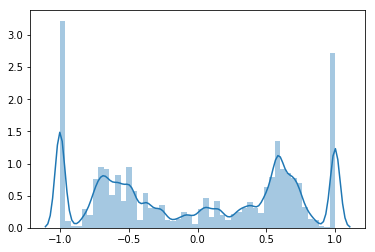

In [18]:
standard_scores = encoder.predict(x_test_scaled).ravel()
#regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=True, label='standard model')
#sns.distplot(regularized_scores, hist=False, label='regularized model')

In [19]:
# encode and decode some images
# note that we take them from the *test* set
# encoded_imgs = encoder.predict(x_test_min_max)
# decoded_imgs_scaled = decoder.predict(encoded_imgs)
#decoded_imgs_scaled = autoencoder.predict(x_test_min_max)
decoded_imgs_scaled = autoencoder.predict(x_test_scaled)
decoded_imgs = supermax*(decoded_imgs_scaled+1)/2
#decoded_imgs = min_max_scaler.inverse_transform(decoded_imgs_scaled)
#decoded_imgs = autoencoder.predict(x_test)


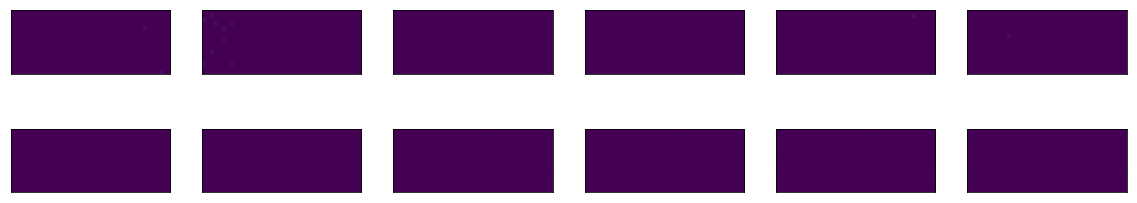

1232


In [20]:
n = 6  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(40, 16).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)



In [21]:
import pandas as pd
filename = '../datos_octubre_2018/p_OF_5mm_161mm003.h5'
conjunto_datos_test=pd.read_hdf(filename,'MC');
conjunto_datos_test.shape

(6296, 3840)

In [22]:
L1A=6;
# hay tres L1 con 640 sensores (40*16)
L1B=0;
# hay dos L1 con 640 sensores (40*16)
X_trained=conjunto_datos_test.values;
x_trained=X_trained;

for i in range (X_trained.shape[0]):
    idea1=X_trained[i,:].reshape(img_rows,(L1A*img_cols));
    ideat=idea1.transpose();
    idea2=ideat.reshape(1,(L1A*img_cols)*img_rows);
    x_trained[i,:] =idea2;
x_tested = x_trained;
print(x_trained.shape)
print(x_tested.shape)

(6296, 3840)
(6296, 3840)


# Vamos a procesar y comprimir con la red

Ahora los particionamos y pasamos por las redes de compresión. Hay una red la A que se utiliza 5 veces

In [23]:

def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))
ideaA=np.zeros((L1A,input_output_dim_A))

cara_externa=x_tested[:,0: L1A*input_output_dim_A] 
cara_externa_reconstruida=np.zeros((x_tested.shape[0],L1A*input_output_dim_A))
for i in range(x_tested.shape[0]):
    for k in range(L1A):
        ideaA[k,:]=x_tested[i,k*input_output_dim_A:k*input_output_dim_A+input_output_dim_A]
    #ideaA_scaled=min_max_scaler.transform(ideaA)
    ideaA_scaled=(2*ideaA/(supermax)) -1
    salida_reconstructed_1_scaled = autoencoder.predict(ideaA_scaled)    
    salida_reconstructed_1 = supermax*(salida_reconstructed_1_scaled+1)/2
    #salida_reconstructed_1 = min_max_scaler.inverse_transform(salida_reconstructed_1_scaled)     
    #salida_reconstructed_1 = ideaA
    
    #entrada_imgs_A=(ideaA-min_A.transpose())/(max_A.transpose()-min_A.transpose())
    #entrada_imgs_A=(ideaA) #he quitado el escalado
    #encoded_imgs_A = sigmoid(np.dot(entrada_imgs_A, Encoder_weights_A) + Encoder_biases_A)
    #decoded_imgs_A= (np.dot(encoded_imgs_A, Decoder_weights_A) + Decoder_biases_A)
    #print(decoded_imgs_A.shape)
    #salida_reconstructed_1 = decoded_imgs_A*(max_A.transpose()-min_A.transpose())+min_A.transpose();
    #salida_reconstructed_1 = decoded_imgs_A #quito el escalado inverso    
 
    hola1=np.reshape(salida_reconstructed_1,(L1A*input_output_dim_A))

    #print(hola.shape)
    salida_total=hola1
    #salida_total[salida_total<0]=0
    #print(salida_total.shape)
    cara_externa_reconstruida[i]=salida_total
  

## Visualizamos los resultados

Visualizamos todos los sensores: 

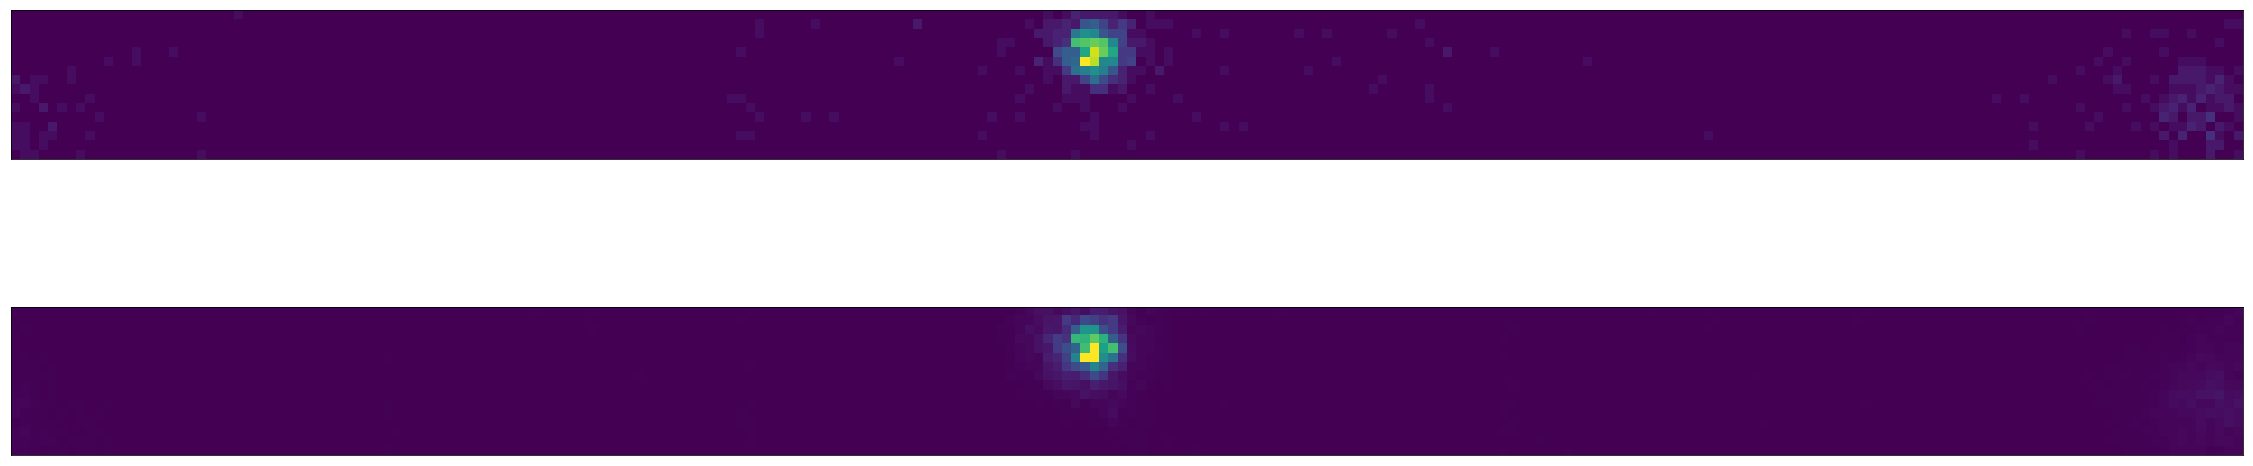

In [24]:
n = 1  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_tested.shape[0])
    idea=1890
    idea= 4299
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose(), vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Visualizamos ahora L1 a L1, teniendo en cuenta que hay de dos tipos:
L1A (con 36 columnas )

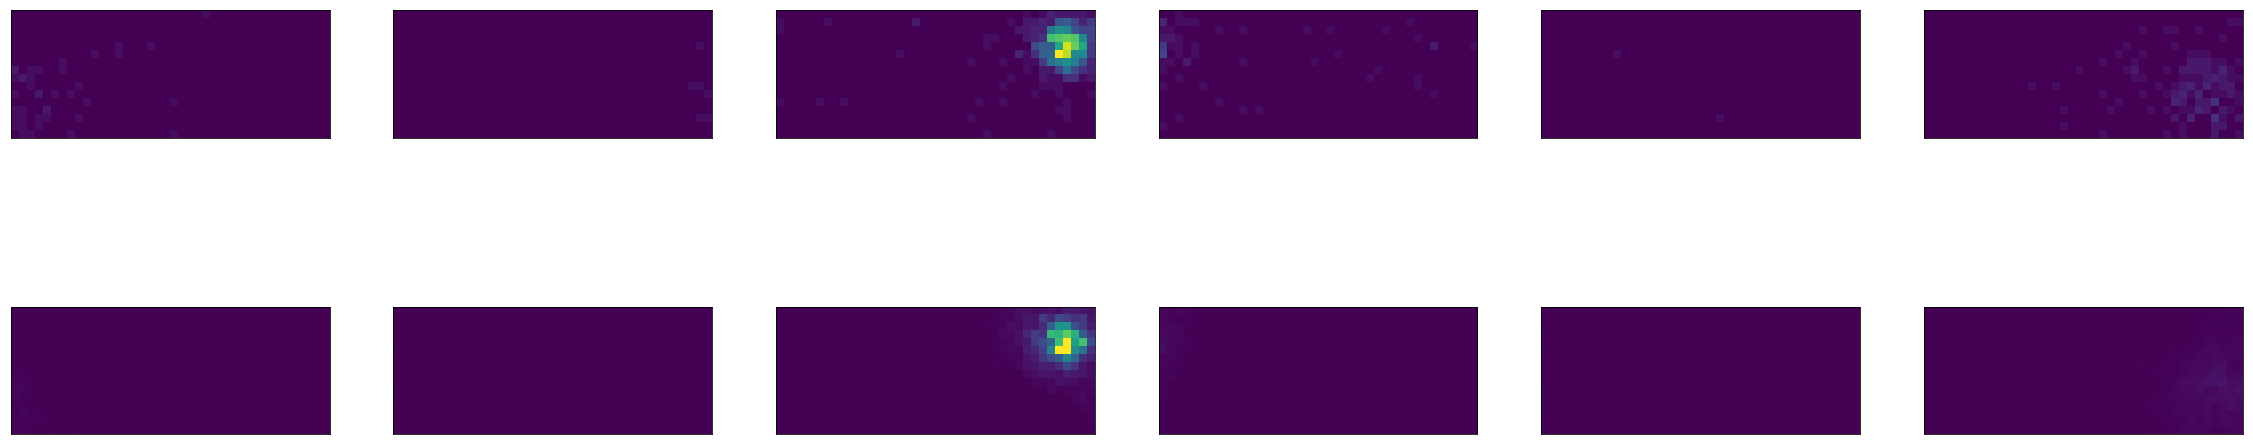

In [25]:
n = L1A  # how many digits we will display
plt.figure(figsize=(40, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(cara_externa[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1+n)
    plt.imshow(cara_externa_reconstruida[idea].reshape(L1A*img_cols, img_rows).transpose()[:,i*img_cols:(i+1)*img_cols] ,vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
i=2
print(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:])
print(np.sum(cara_externa[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

In [27]:
print(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:].astype(int))
print(np.sum(cara_externa_reconstruida[idea].reshape(L1A*img_cols,img_rows)[i*img_cols:(i+1)*img_cols,:]))

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0

In [28]:
print(idea)
np.sum(cara_externa_reconstruida,axis=0)

4299


array([ 985.86481369, 1110.71094501, 1067.89227188, ..., 1013.54929888,
       1063.12700355,  913.19185138])

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


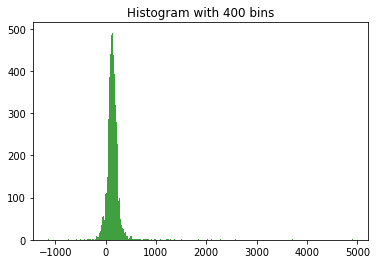

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 400
    # variables        = 3
    chi-square         = 17008.7529
    reduced chi-square = 42.8432063
    Akaike info crit   = 1506.00753
    Bayesian info crit = 1517.98192
[[Variables]]
    amp:  483.517141 +/- 2.73454389 (0.57%) (init = 200)
    cen:  128.023926 +/- 0.47851988 (0.37%) (init = 0)
    wid:  103.622793 +/- 0.67672930 (0.65%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



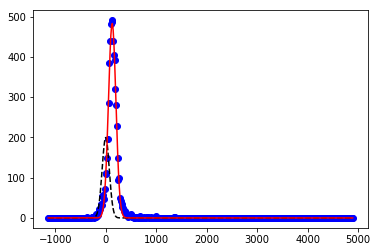

In [29]:
veamos_energia=(np.sum(cara_externa_reconstruida, axis=1))-(np.sum(cara_externa, axis=1))
n, bins, patches = plt.hist(veamos_energia, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=200, cen=0, wid=100)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()